## Библиотеки

Помимо `pandas`, будем использовать новую библиотеку для графиков - `matplotlib`.

In [ ]:
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot') #стиль
matplotlib.rcParams['figure.figsize'] = (12, 5) #размер графика

## Загрузим данные

Ты ведь помнишь, как это делать? Повторим еще раз :). Мы используем для этого функции `pd.read_hdf`.

In [ ]:
df = pd.read_hdf("../input/data.h5")

print(df.shape)
df.sample(5)

(820906, 9)


,order_id,customer_id,product_id,quantity,price_unit,price_total,country_id,order_date,is_canceled
468391,30003,3493,2426,2,165,330,0,2010-02-12 12:34:00,False
743895,48570,753,742,5,195,975,0,2010-10-31 14:25:00,False
572495,37517,673,192,1,210,210,0,2010-05-30 12:30:00,False
168064,11943,2935,271,12,125,1500,0,2011-06-21 12:35:00,False
232869,16216,74,120,6,295,1770,0,2011-09-02 13:00:00,False


## Целевая переменная


<blockquote>
— Скажите, пожалуйста, куда мне отсюда идти? <br />
— А куда ты хочешь попасть? — ответил Кот. <br />
— Мне все равно — сказала Алиса. <br />
— Тогда все равно, куда и идти, — заметил Кот. <br />
— Только бы попасть куда-нибудь, — пояснила Алиса. <br />
— Куда-нибудь ты обязательно попадешь, — сказал Кот. <br />
— Нужно только достаточно долго идти.<br />
<br />
    
Алиса в стране чудес (Льюис Кэрролл)
</blockquote> 



Иногда в жизни полезно поблуждать, но в нашем случае, мы хотим как можно более осознанно подходить к нашим решениям.
Мы хотим знать, куда мы идем. Ведь мы уже знаем, где хотим оказаться?

Мы хотим выбрать группы/сегменты, которые дает «большинство» (больше доходов и прибыли).
Вспомним код из предыдущего урока и посчитаем накопительную сумму (все в одной ячейке).

In [ ]:
df_customers = (
    df[ ["price_total", "customer_id"] ]
    .groupby("customer_id")
    .agg("sum")
    .reset_index()
    .sort_values(by="price_total", ascending=False)
    .rename(columns={"price_total": "customer_price_total"})
)


df_customers["cumsum"] = df_customers["customer_price_total"].cumsum()
df_customers.head(5)

,customer_id,customer_price_total,cumsum
448,448,61130939,61130939
907,907,53007160,114138099
2647,2647,33695110,147833209
179,179,31039769,178872978
66,66,29774259,208647237


Теперь мы хотим создать новый столбец, например, с названием `most_revenue_customer`, где значение может быть `True` или `False`.

Значение `True` будет, когда этот конкретный покупатель находится в группе ~20%, которая приносит 80% дохода.

In [ ]:
value_80prc = int(df["price_total"].sum() * 0.8)
df_customers["most_revenue_customer"] = df_customers["cumsum"] < value_80prc

df_customers["most_revenue_customer"].value_counts()

False    4555
True     1324
Name: most_revenue_customer, dtype: int64

`value_counts()` пишем в конце. Кстати, запомни эту функцию - она весьма удобная и часто применяется, когда нужно проверить, какие уникальные значения в столбце и сколько их (в штуках).

В нашем случае у нас `1324` клиента, которые входят в число ключевых бизнес-клиентов, так как приносят компании 80% ее доходов. Если мы «потеряем» этих клиентов, у компании будут большие проблемы -80% доходов. Если не учитывать остальных клиентов (например мы потеряем остальные 80% клиентов), то у компании будет только -20% потерь. Чувствуешь разницу, правда?

Кстати, в `.value_counts` Ты можешь нормализовать результат (указав аргумент` normalize=True`). И тогда можешь увидеть результат, выраженный в процентах. Иногда это удобно. Смотрим на примере, как это делается 👀.

In [ ]:
df_customers["most_revenue_customer"].value_counts(normalize=True)

False    0.774792
True     0.225208
Name: most_revenue_customer, dtype: float64

Мы видим, что `most_revenue_customer` (то есть ценность`True`) имеет **22,5%** (посчитаем `0.225208 * 100%` и округлим до `22,5%` 😉).

Давай сегмент клиентов (наш `top_customers`), которые принесли 80% дохода, соберем лично (ну или точнее по `customer_id`). Для этого воспользуемся функцией `unique()`, которая вернет список идентификаторов клиентов (уникальные идентификаторы, означающие, что каждый идентификатор встречается ровно один раз). 

Кроме того, мы конвертируем результат в набор (анг. `set`), который гарантирует нам, что каждый customer_id будет учтен только раз.

Кодим!

In [ ]:
top_customers = set(df_customers[ df_customers["most_revenue_customer"] ]["customer_id"].unique())
#top_customers
len(top_customers)

1324

Теперь мы также можем добавить новый столбец `most_revenue_customer` в исходный `df`. 

Используя функцию `map`, мы перебираем данные -  значение за значением и проверяем, находится ли покупатель (`customer_id`) в наборе `top_customers`. Есть два возможных ответа: да или нет (`True` или `False`).

In [ ]:
df["most_revenue_customer"] = df["customer_id"].map(lambda x: x in top_customers)
df["most_revenue_customer"].value_counts()

True     539072
False    281834
Name: most_revenue_customer, dtype: int64

Появилось слово `lambda`, так называемая анонимная функция. Сейчас я не буду вдаваться в подробности. Самым важным в этой функции `lambda x: x in top_customers` - является тело функции, в котором прописывается условие `x in top_customers`. Где `x` - это имя переменной, в данном случае `x` - это `customer_id`.

В итоге мы создали новый столбец с названием `most_revenue_customer`. Давай еще раз посмотрим (немного с другой стороны), что там внутри - для этого используем функцию 
`.value_counts(normalize=True)`.

In [ ]:
df["most_revenue_customer"].value_counts(normalize=True)

Видно, что наибольшее количество «строк» (объектов) в нашем `df` было создано клиентами из сегмента `most_revenue_customer`. Это говорит о том, что эти клиенты сделали (и/или):
- много заказов;
- заказали много разных продуктов в одном заказе.

Мы проверим оба случая, чтобы лучше понять, что **нужно сделать**, чтобы попасть в сегмент `most_revenue_customer`.

Когда мы знаем, к чему хотим стремиться, это уже достаточно много... 💪 Задумайся на мгновение, как часто Ты осознаешь, к чему именно нужно стремиться? 🤔


## Если мы знаем «кто», остается ответить на вопрос «как»?
Управление своей энергией имеет решающее значение в жизни 🔋. Все просто! У каждого из нас очень ограниченное и конечное количество энергии. Тебе решать, кому ее отдать. Давай проведем мысленный эксперимент. Представь, у Тебя в кармане 1000 рублей. Ведь можно потратить их по-разному, верно? Начиная с того, что Ты всегда можешь их выбросить в окно или закопать в землю (или спалить на костре), но  также можно купить книгу или мини-курс и инвестировать в свое развитие. Каждое из этих решений повлияет на то, где Ты будешь в итоге. Здесь работает простое правило - то, где Ты сейчас находишься, - это сумма (эффект) всех Твоих предыдущих (осознанных или неосознанных) решений.


#### Поэтому стоит позаботиться о том, как Ты распоряжаешься своей энергией

Мы уже убедились собственными глазами, что некоторые клиенты приносят (гораздо) больший доход. Хотелось бы, чтобы таких клиентов было побольше, не так ли? Вопрос: **как отличить именно этих клиентов от других, глядя в будущее, а не в прошлое (не дожидаясь пока купят или не купят)?** Собственно, как можно описать (охарактеризовать) такого клиента?

👀 Почему важно предугадывать поведение клиента прежде, чем он совершит покупку? Потому что есть много других затрат, например, расходы на рекламу и куча другой головной боли (все, кто имел с этим дело - сейчас активно "машут головой"). Поэтому заранее узнать, что характеризует «идеального клиента», и "заинвестировать" большую часть своего внимания и энергии в поиск людей, которым нужно именно Твое решение (продукт или услуга).

Еще раз повторю, но это должно стать очевидным. Мы хотим понять, чем «идеальные клиенты» отличаются от других клиентов. Кстати, здесь слово «идеальный» может использоваться во многих контекстах: идеальный клиент, идеальный продукт, идеальный заказ, идеальный период времени и т. д. Это означает, что у нас есть ситуация, когда можно сделать меньше и получить больше, естественно, проще, потому что мы находимся в нужном месте, в нужное время и с нужным решением для нужных клиентов и т. д.

Отсюда предполагаем, что каждое из этих измерений/объектов (клиент, продукт, заказ и т. д.) имеют определенные свойства, атрибуты или характеристики, которые могут отличать «идеал» от «других». В машинном обучении (англ. `machine learning`) мы называем эти свойства признаками (англ. `features`). Есть даже такой процесс (который очень важен) по созданию (изобретению) новых признаков, которые лучше описывают объект (покупателя, продукт и т. Д.). У этого процесса есть свое название "инженерия признаков" (англ. `feature engineering`).

Этим мы и займемся :)


## Как Ты можешь описать клиента?

Поиск новых и значимых признаков - это искусство большее, чем наука. Лучше всего показать это на примерах, потому что универсального алгоритма не существует (и это даже хорошо, потому что иначе этот процесс давно уже был бы автоматизирован).

👀 На первый взгляд может показаться, что у нас очень мало информации о клиентах, продуктах (например, только идентификатор), но на самом деле необходимо уметь извлекать ее, на основании имеющихся данных.

Начнем с простого примера, связанного с клиентом.

### Сколько заказов выполнил каждый клиент?

In [ ]:
df_customer_orders = (
    df[ ["customer_id", "order_id"] ]
        .groupby(["customer_id"])
        .agg(lambda x: len(set(x)) )
        .reset_index()
        .rename(columns={"order_id": "count_orders"})
        
)

df_customer_orders["most_revenue_customer"] = df_customer_orders["customer_id"].map(lambda x: x in top_customers)
df_customer_orders

,customer_id,count_orders,most_revenue_customer
0,0,159,True
1,1,40,True
2,2,30,True
3,3,9,False
4,4,14,True
...,...,...,...
5874,5874,2,False
5875,5875,1,False
5876,5876,1,False
5877,5877,1,False


☝️ Обрати внимание, что мы также добавили новый столбец в `df_customer_orders` под названием `most_revenue_customer`, который имеет значение `True` или `False`. 

Мы видим, что у `customer_id = 0` 159 заказов, у `customer_id = 5878` - два заказа. Давай сделаем быструю перепроверку `double-check`, чтобы убедиться, что мы все делаем правильно.

In [ ]:
df[ df["customer_id"] == 5878 ][ ["customer_id", "order_id", "product_id", "order_date"] ]

,customer_id,order_id,product_id,order_date
805795,5878,52178,694,2010-11-30 15:52:00
806122,5878,52202,694,2010-11-30 18:46:00


Все правильно - у `customer_id=5878` два заказа. Интересно, что это был тот же продукт (`product_id=694`), а второй заказ был сделан через ~ 3 часа (2:54 часа). Потом он больше не вернулся. Исходя из этого, можно предположить ряд вещей, которые еще можно проверить, но пока оставим это.

Пока, помимо `customer_id`, у нас есть вторая функция `count_orders`, которая определяет количество заказов, сделанных этим клиентом.

Мы начнем видеть, действительно, ли количество покупок «помогает» охватить сегмент клиентов `most_revenue_customer`.

In [ ]:
(
    df_customer_orders[ ["most_revenue_customer", "count_orders"] ]
    .groupby("most_revenue_customer")
    .agg(['mean', 'min', 'max', 'median', 'std'])
)

count_orders                           
                              mean min  max median        std
most_revenue_customer                                        
False                     3.446542   1   30      2   2.913319
True                     21.305891   1  468     15  27.836488

### Анализируем результат

- `min=1` для `most_revenue_customer=True`, есть как минимум один клиент, который находится в сегменте `most_revenue_customer`, но при этом сделал всего лишь один заказ (но зато какой? хотя это нужно перепроверить, возможно, все дело в "размере" заказа).
- `max` для `most_revenue_customer=True` 468, для `most_revenue_customer=False` максимум 30. Похоже, что любой клиент, у которого больше 30 заказов, переходит к `most_revenue_customer`. Вероятно, это порог, превышающий определенную сумму (такую гипотезу стоит также перепроверить).
- медиана (то есть половина) для `most_revenue_customer = True` составляет 15 (это означает, что половина клиентов имеет как минимум 15+ заказов или наоборот) в случае `most_revenue_customer = False`, половина клиентов имеет только 3 заказа.

Уже на основании этой информации можно сделать интересные выводы.

Время для заданий. Проведи аналогичный анализ для продуктов (как мы выше сделали для клиентов).

## Задание 3.1

Только что мы подготовили набор `top_customers`. Теперь сделаем то же самое, только для продуктов и сохраним результат в переменной с именем `top_products`.

### 💡 Советы
1. Сначала нужно вычислить `most_revenue_product` с возможными ответами `True` или `False`.
2. Для этого стоит подсчитывать `cumsum` для продуктов.
3. Мы уже сделали это для `df_customers`, теперь мы хотим получить идентичный `df_products`.
4. Нам нужно определиться - что такое большинство (сколько процентов). Предположим, что большинство - это 80% `value_80prc = int(df ["price_total"].sum() * 0.8`.
5. Затем уже можно вычислить `most_revenue_product`, например, `df_products["most_revenue_product"] = df_products["cumsum"] < value_80prc`.
6. И теперь `set (df_products [df_products ["most_revenue_product"]] ["product_id"].unique())`.
7. Наконец, результат записываем в переменную `top_products`.


### Если у Тебя остались вопросы, задай 🙏 в чате Slack [#dwthon_day3](https://bit.ly/3f6tLfV)! Помни, что обучение начинается с вопросов. Очень хорошо, что они возникают :)

In [ ]:
df_products = (
    df[ ["price_total", "product_id"] ]
    .groupby("product_id")
    .agg("sum")
    .reset_index()
    .sort_values(by="price_total", ascending=False)
    .rename(columns={"price_total": "product_price_total"})
)

df_products["cumsum"] = df_products["product_price_total"].cumsum()

value_80prc = int(df["price_total"].sum() * 0.8)

df_products["most_revenue_product"] = df_products["cumsum"] < value_80prc

top_products = set(df_products[ df_products["most_revenue_product"] ]["product_id"].unique())
len(top_products)

925

Стоит пойти еще дальше, если у Тебя есть энергия и желание, чтобы посмотреть на заказы. Каждый заказ состоит из продуктов.

Например, давай проверим, какие продукты покупатель купил хотя бы один раз. 

In [ ]:
df_customer_products = (
    df[ ["customer_id", "product_id"] ]
        .groupby(["customer_id"])
        .agg(lambda x: len(set(x)) )
        .reset_index()
        .rename(columns={"product_id": "count_unique_products"})
        
)

df_customer_products["most_revenue_customer"] = df_customer_products["customer_id"].map(lambda x: x in top_customers)
df_customer_products

,customer_id,count_unique_products,most_revenue_customer
0,0,93,True
1,1,184,True
2,2,139,True
3,3,40,False
4,4,11,True
...,...,...,...
5874,5874,46,False
5875,5875,21,False
5876,5876,69,False
5877,5877,33,False


Видим следующее. Например, клиент `customer_id = 0` купил 93 продукта, по крайней мере столько разновидностей продуктов (`product_id`).

Другой пример, клиент `customer_id = 5878` (последняя строка в таблице выше ☝️) приобрел только один вид продукта. Теперь давай проведем аналогичный анализ, как указано выше. Для начала я помогу Тебе.

In [ ]:
(
    df_customer_products[ ["most_revenue_customer", "count_unique_products"] ]
    .groupby("most_revenue_customer")
    .agg(['mean', 'min', 'max', 'median', 'std'])
)

count_unique_products                             
                                       mean min   max median         std
most_revenue_customer                                                   
False                             47.309330   1   408     32   49.811765
True                             189.253776   1  2353    152  174.096217

## 🧠 Включим критическое мышление

Подумай, что это значит? Сделай выводы и рассмотри (придумай гипотезы и как это можно перепроверить простым образом - лучше всего используя только те данные, которые у нас имеются).

## 🧠 Включим критическое мышление

Так уж получилось, что время играет важную роль в нашей жизни. Если подумать, то очень важно учитывать время в графике. Представь, что с завтрашнего дня запретят понятие времени (во время «пандемии» даже это может «произойти» 😉), что тогда? Что это значит для Тебя?

Время очень важно! От этого зависит большая часть нашей деятельности. В контексте этой задачи время сильно влияет на то, когда мы покупаем подарки - т.к. подарки (как правило) должны иметь повод.

При случае, добавлю еще раз. По моему опыту, улавливание контекста критически важный навык при анализе данных. Время - один из ключевых контекстов, о котором всегда нужно помнить! Я покажу сейчас на простом примере, почему я так много внимания уделяю «времени».

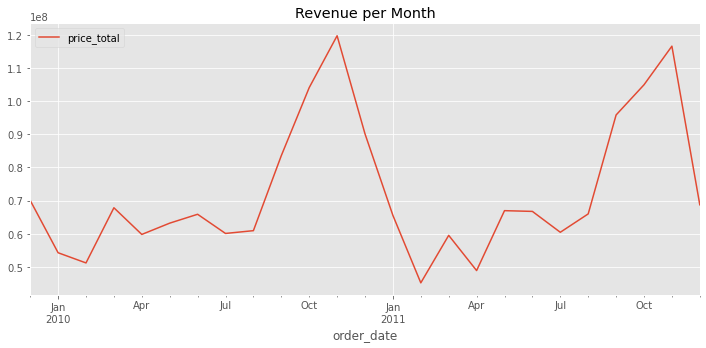

In [ ]:
df.index = df.order_date
df[ ['price_total'] ].resample('m').agg("sum").plot(title="Revenue per Month");

График показывает, что доход магазина очень сильно меняется в течение года. Фактически, можно даже показать месяцы, когда материализуется 80% доходов. Видны сезоны. Поздняя осень и начало зимы - самые привлекательные времена для продажи (в этом магазине).

Несколько технических предложений.

- Мы назначили `df.index = df.order_date` индексом даты, чтобы можно было использовать `resample`.
- `resample('M')` это функция, которая облегчает жизнь при работе с временными рядами. Аналогичного эффекта можно добиться и с помощью `groupby`, но нам придется больше помучаться (а зачем?).
- параметр `M` в `resample` означает `month`, т.е. собирать данные за месяц, можно также поставить `d` из `day` или даже `7d`, тогда это будет каждые 7 дней. Давай проверим :)

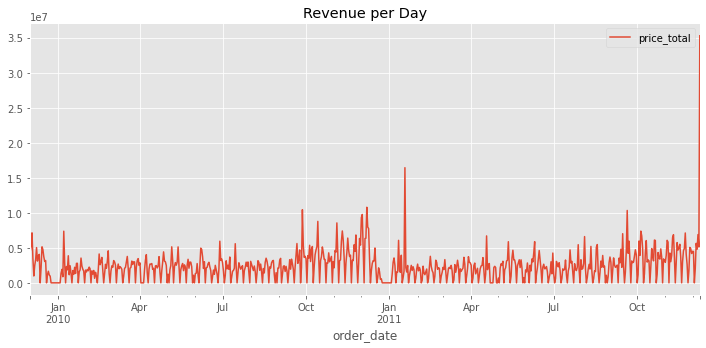

In [ ]:
df[ ['price_total'] ].resample('d').agg("sum").plot(title="Revenue per Day");

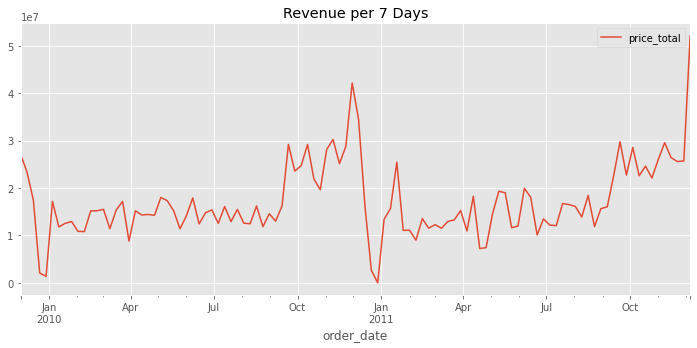

In [ ]:
df[ ['price_total'] ].resample('7d').agg("sum").plot(title="Revenue per 7 Days");

- `agg ("sum")` означает функцию суммы, но это может быть что-то еще, например, `max`,` min`, `median`,` std` или все сразу. Давай проверим.

⌛️ Внимание - эта ячейка считается дольше!

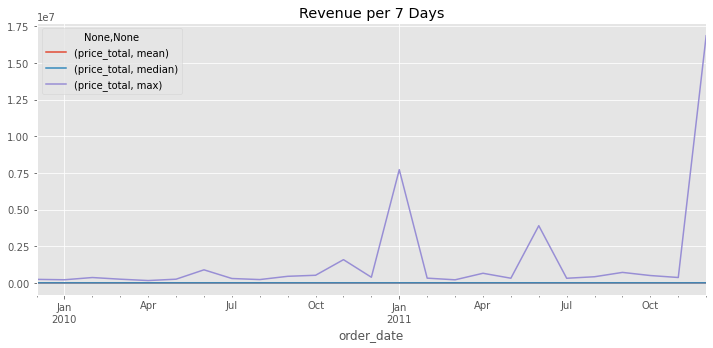

In [ ]:
df[ ['price_total'] ].resample('1m').agg(["mean", "median", "max"]).plot(title="Revenue per 7 Days");

Ты можешь видеть, что иногда `max` значительно выделяется. Звучит, как тема для обсуждения того, «почему» это происходит. Возможно, это какие-то аномалии.

Переключаемся на заказы - `order_id`. Проверим количество заказов в месяц.

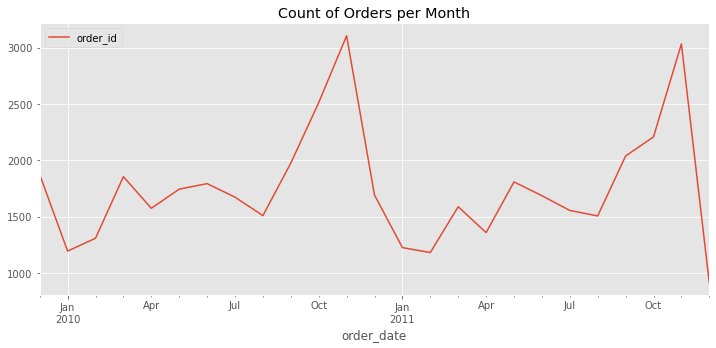

In [ ]:
df[ ['order_id'] ].resample('1m').agg(lambda x: len(set(x)) ).plot(title="Count of Orders per Month");

Время подумать. Сделать выводы :).